<a href="https://colab.research.google.com/github/oshodiS/AII/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

# 0. Importing libraries

In [1]:
%%capture
! pip install fitter 

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from itertools import chain
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from fitter import Fitter
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp



# 1. Load and inspect the dataset

In [3]:
df = pd.read_csv('data/AMS_descritt_noSM_meltD_adim.csv', sep=',', encoding='utf-8')
df.drop(df.columns[[0]], axis=1, inplace=True)
df.head()

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679


In [ ]:
df.columns

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')

In [4]:
# Unique duration values

DURATION = df['duration[h]'].unique()
print(DURATION)

[ 1  3  6 12 24]


## 1.1. Preprocess the dataset
spiegazione 

In [5]:
# create a dictionary of dataframes, one for each duration
dfs = {}
for duration in DURATION:
    dfs[f'{duration}'] = df[df['duration[h]'] == duration].drop("duration[h]", axis=1, inplace=False)
    dfs[f'{duration}'].reset_index(drop=True, inplace=True)


In [6]:
dfs['3']

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,VarClimSowP(mm),X,Y,AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,281.338470,633069.81,4890553.68,1.106796,51.500000,0.925308,0.129267,1.519957,1.309257,1.119201
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,281.338470,633069.81,4890553.68,0.893204,51.500000,0.925308,0.129267,1.519957,1.309257,1.119201
2,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,281.338470,633069.81,4890553.68,1.184466,51.500000,0.925308,0.129267,1.519957,1.309257,1.119201
3,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,281.338470,633069.81,4890553.68,0.815534,51.500000,0.925308,0.129267,1.519957,1.309257,1.119201
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,23.933985,555576.92,4921743.21,0.876011,53.195652,0.783417,0.300108,2.163958,1.674796,1.233560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54923,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,10.285090,696822.00,5044294.00,0.946180,37.836364,0.869541,0.265935,2.092882,1.659420,1.268428
54924,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,10.285090,696822.00,5044294.00,1.009611,37.836364,0.869541,0.265935,2.092882,1.659420,1.268428
54925,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,10.285090,696822.00,5044294.00,0.459875,37.836364,0.869541,0.265935,2.092882,1.659420,1.268428
54926,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,10.285090,696822.00,5044294.00,1.009611,37.836364,0.869541,0.265935,2.092882,1.659420,1.268428


In [7]:
# maximum value of AMS in each dataframe
for duration in DURATION:
    print(f"maximum AMS in {duration}h: {dfs[f'{duration}']['AMS'].max()}")

maximum AMS in 1h: 4.782464297575557
maximum AMS in 3h: 4.905896003540713
maximum AMS in 6h: 5.373404747735238
maximum AMS in 12h: 5.915663202234329
maximum AMS in 24h: 6.288661312900612


In [8]:
def standardize_AMS(df, k = 1, IdD = True):
    """
        df: dataframe
        k: Multiplication factor to extend the range of AMS values. Defaults to 1.
        IdD: To specify how standardize. Defaults to True.
    
    """
    
    if IdD:
        df['AMS'] = df.apply(lambda row: row['AMS'] * row['IdD'], axis=1)
    
    min_AMS = df['AMS'].min()
    max_AMS = df['AMS'].max() * k 
    
    df['AMS'] = df.apply(lambda row: (row['AMS'] - min_AMS) / (max_AMS - min_AMS), axis=1)

    return df


In [9]:
std_dfs = {}
for duration in DURATION:
    std_dfs[f'{duration}'] = standardize_AMS(dfs[f'{duration}'], IdD = False)

In [10]:
std_dfs['3']

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,VarClimSowP(mm),X,Y,AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,281.338470,633069.81,4890553.68,0.223188,51.500000,0.925308,0.129267,1.519957,1.309257,1.119201
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,281.338470,633069.81,4890553.68,0.179515,51.500000,0.925308,0.129267,1.519957,1.309257,1.119201
2,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,281.338470,633069.81,4890553.68,0.239070,51.500000,0.925308,0.129267,1.519957,1.309257,1.119201
3,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,281.338470,633069.81,4890553.68,0.163633,51.500000,0.925308,0.129267,1.519957,1.309257,1.119201
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,23.933985,555576.92,4921743.21,0.175999,53.195652,0.783417,0.300108,2.163958,1.674796,1.233560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54923,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,10.285090,696822.00,5044294.00,0.190347,37.836364,0.869541,0.265935,2.092882,1.659420,1.268428
54924,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,10.285090,696822.00,5044294.00,0.203317,37.836364,0.869541,0.265935,2.092882,1.659420,1.268428
54925,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,10.285090,696822.00,5044294.00,0.090911,37.836364,0.869541,0.265935,2.092882,1.659420,1.268428
54926,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,10.285090,696822.00,5044294.00,0.203317,37.836364,0.869541,0.265935,2.092882,1.659420,1.268428


In [ ]:
'''durations = [1, 3, 6, 12, 24]

grouped_AMS = df.groupby(['ID', 'duration[h]'])['AMS'].apply(list).reset_index()
grouped_IdD = df.groupby(['ID', 'duration[h]'])['mean_IdD'].unique().apply(lambda x:  x[0] if len(x) > 0 else None).reset_index()

pivoted_AMS = grouped_AMS.pivot(index='ID', columns='duration[h]', values='AMS')
pivoted_IdD = grouped_IdD.pivot(index='ID', columns='duration[h]', values='mean_IdD')

pivoted_AMS.columns = [f'AMS_{col}' for col in pivoted_AMS.columns]
pivoted_IdD.columns = [f'IdD_{col}' for col in pivoted_IdD.columns]

pivoted_AMS.reset_index(inplace=True)
pivoted_IdD.reset_index(inplace=True)

print(pivoted_AMS)
new_df = pd.merge(new_df, pivoted_AMS, on='ID')
new_df = pd.merge(new_df, pivoted_IdD, on='ID')

new_df.head()'''

"durations = [1, 3, 6, 12, 24]\n\ngrouped_AMS = df.groupby(['ID', 'duration[h]'])['AMS'].apply(list).reset_index()\ngrouped_IdD = df.groupby(['ID', 'duration[h]'])['mean_IdD'].unique().apply(lambda x:  x[0] if len(x) > 0 else None).reset_index()\n\npivoted_AMS = grouped_AMS.pivot(index='ID', columns='duration[h]', values='AMS')\npivoted_IdD = grouped_IdD.pivot(index='ID', columns='duration[h]', values='mean_IdD')\n\npivoted_AMS.columns = [f'AMS_{col}' for col in pivoted_AMS.columns]\npivoted_IdD.columns = [f'IdD_{col}' for col in pivoted_IdD.columns]\n\npivoted_AMS.reset_index(inplace=True)\npivoted_IdD.reset_index(inplace=True)\n\nprint(pivoted_AMS)\nnew_df = pd.merge(new_df, pivoted_AMS, on='ID')\nnew_df = pd.merge(new_df, pivoted_IdD, on='ID')\n\nnew_df.head()"

In [ ]:
'''# Take only the rows with unique ID
df_unique = new_df.drop_duplicates(subset=['ID'], keep='first')
df_unique = df_unique.drop(['duration[h]', 'mean_IdD'], axis=1)
df_unique.reset_index(drop=True, inplace=True)'''

"# Take only the rows with unique ID\ndf_unique = new_df.drop_duplicates(subset=['ID'], keep='first')\ndf_unique = df_unique.drop(['duration[h]', 'mean_IdD'], axis=1)\ndf_unique.reset_index(drop=True, inplace=True)"

In [11]:
df2 = pd.read_csv('data/gumMap_statbench_Gumfit_NEW.csv', sep=',', encoding='utf-8')
df2.head()

,Unnamed: 0,ID,Nome,md_1h,md_3h,md_6h,md_12h,md_24h,q1h_0.80,q1h_0.95,...,q_3h_0.99,q_6h_0.80,q_6h_0.95,q_6h_0.99,q_12h_0.80,q_12h_0.95,q_12h_0.99,q_24h_0.80,q_24h_0.95,q_24h_0.99
0,0,5005,'Anzola_Dellemilia',1.0,1.0,1.0,1.0,1.0,1.297268,1.770921,...,2.204652,1.262136,1.679814,2.142859,1.256130,1.664236,2.116671,1.257223,1.667072,2.121439
1,1,5007,'Argelato',1.0,1.0,1.0,1.0,1.0,1.307714,1.798013,...,2.270210,1.272879,1.707674,2.189696,1.264559,1.686097,2.153422,1.257970,1.669008,2.124694
2,2,5015,'Bardi_Centrale',1.0,1.0,1.0,1.0,1.0,1.271656,1.704500,...,2.174044,1.257236,1.667106,2.121495,1.251259,1.651604,2.095435,1.253316,1.656940,2.104405
3,3,5141,'Invaso',1.0,1.0,1.0,1.0,1.0,1.271679,1.704561,...,2.174045,1.257236,1.667106,2.121496,1.251259,1.651605,2.095436,1.253324,1.656960,2.104438
4,4,5143,'Isola_Di_Palanzano_Centrale',1.0,1.0,1.0,1.0,1.0,1.265930,1.689653,...,2.173967,1.257225,1.667077,2.121446,1.251233,1.651538,2.095324,1.250087,1.648565,2.090326


## 1.2. Train-Val-Test split

In [12]:
# Take the first 100 ID from df2 and use them to create the test sets
test_ID = df2['ID'].to_list()[:100]

test_dfs = {}
for duration in DURATION:
    test_dfs[f'{duration}'] = std_dfs[f'{duration}'][std_dfs[f'{duration}']['ID'].isin(test_ID)]
    test_dfs[f'{duration}'].reset_index(drop=True, inplace=True)


In [13]:
# Drop the test set from std_dfs and then create the train sets and validation sets
for duration in DURATION:
    std_dfs[f'{duration}'] = std_dfs[f'{duration}'].drop(std_dfs[f'{duration}'][std_dfs[f'{duration}']['ID'].isin(test_ID)].index,)
    std_dfs[f'{duration}'].reset_index(drop=True, inplace=True)

validation_split = 0.1

train_dfs = {}
val_dfs = {}
for duration in DURATION:
    train_dfs[f'{duration}'], val_dfs[f'{duration}'] = train_test_split(std_dfs[f'{duration}'], test_size=validation_split, random_state=42)
    train_dfs[f'{duration}'].reset_index(drop=True, inplace=True)
    val_dfs[f'{duration}'].reset_index(drop=True, inplace=True)

In [14]:
train_dfs['3']

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,VarClimSowP(mm),X,Y,AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,9162,'Lecco_Via_Sora',282.547531,49.481426,7.358590,6.876921,204.597871,41.207173,235.482223,461.481440,...,10.050817,531071.00,5078912.00,0.278673,48.035294,0.843829,0.293843,2.195550,1.716600,1.284576
1,12389,'Carcoforo',1503.434625,153.863643,29.326207,12.711749,176.098867,88.626781,338.975030,332.438539,...,234.865265,426444.00,5084376.00,0.292481,50.495263,0.836012,0.285218,2.148055,1.683164,1.263821
2,5126,'Forli',28.513426,2.609342,0.435942,0.285487,118.752622,89.483449,24.737697,12.379064,...,5.954321,744076.21,4900690.26,0.082840,33.301205,0.825165,0.282329,2.123920,1.663737,1.248642
3,5276,'San_Benedetto_In_Alpe',619.586770,90.153743,19.262117,8.199261,168.916188,92.213715,61.828073,249.049105,...,28.295330,715463.62,4873693.67,0.299571,36.477778,0.855167,0.238222,1.951023,1.562732,1.212486
4,16076,'Porrino',823.721317,109.442109,21.803450,7.504031,161.794434,82.870609,129.473226,386.339120,...,84.407043,639275.00,4885950.00,0.166370,49.462069,0.822165,0.304437,2.222620,1.726402,1.278802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46655,8072,'Colle_Del_Melogno',1017.392522,148.313182,20.703809,7.836887,164.489004,67.864609,325.281240,363.897139,...,68.329819,436307.14,4897988.10,0.075316,61.000000,0.787979,0.332043,2.315428,1.774213,1.286024
46656,18022,'Naturno_-_Naturns',611.608689,121.523971,13.241030,15.038922,132.092120,94.217896,173.771299,793.199256,...,9.533550,652371.00,5167937.00,0.131590,23.375000,0.852139,0.231423,1.916721,1.539511,1.199260
46657,16177,'Consuma',944.849158,56.226250,12.355154,5.672587,214.207579,109.720909,80.130591,444.802281,...,31.726362,708125.00,4851395.00,0.260061,39.623188,0.850712,0.270816,2.096508,1.655090,1.256920
46658,5031,'Bologna_Idrografico',56.358650,9.241380,1.418355,0.779833,162.085601,131.814673,73.991208,11.408480,...,9.792802,686515.48,4930073.52,0.140246,33.373494,0.834593,0.269108,2.072531,1.633897,1.238239


## 1.3. Dataset inspection

#### Timeseries length distribution for each duration, both for training and validation

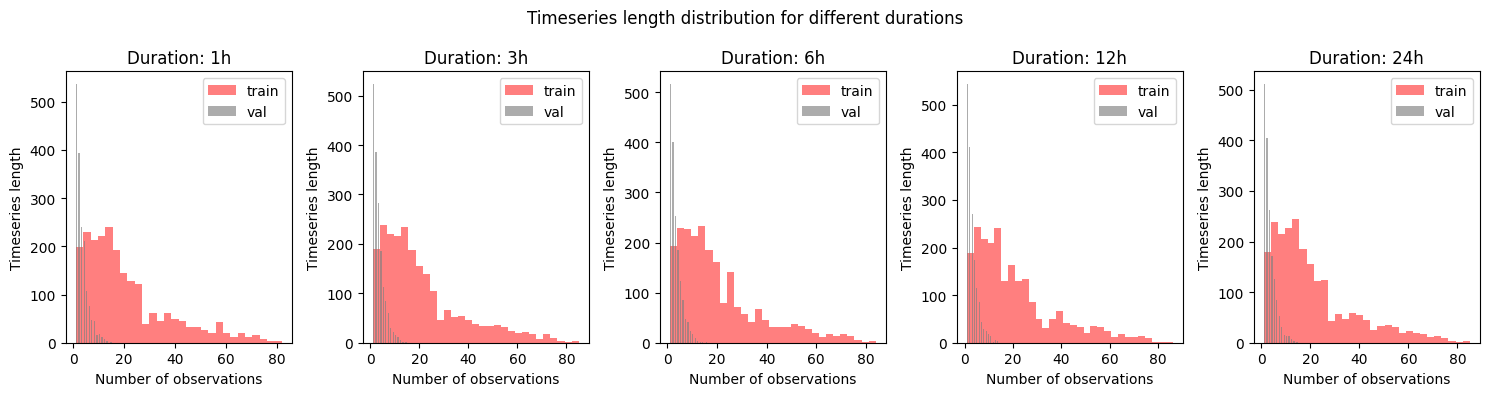

In [15]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4))  # 1 row, 5 columns
fig.suptitle("Timeseries length distribution for different durations")

for i, duration in enumerate(DURATION):
    ax = axes[i]
    ax.hist(train_dfs[f'{duration}']['ID'].value_counts(), bins='auto', alpha=0.5, label='train', color='red')
    ax.hist(val_dfs[f'{duration}']['ID'].value_counts(), bins='auto', alpha=0.65, label='val', color='gray')
    ax.legend()
    ax.set_title(f"Duration: {duration}h")
    ax.set_xlabel("Number of observations")
    ax.set_ylabel("Timeseries length")

plt.tight_layout()  
plt.show()

In [209]:
'''
def compute_timeseries_length(df, duration):
    lenghts = []
    for i in range(len(df)):
        series = df['AMS'+str(duration)][i]
        if np.isnan(series).any():
            lenghts.append(0)
        else:
            lenghts.append(len(series))
    return lenghts

def plot_timeseries_length(df_train, df_val, durations):
    fig, axs = plt.subplots(1, len(durations), figsize=(20, 5))
    for i, duration in enumerate(durations):
        lenghts_train = compute_timeseries_length(df_train, duration)
        lenghts_val = compute_timeseries_length(df_val, duration)
        axs[i].set_ylabel('Percentage')
        axs[i].set_title('Duration: '+str(duration)+'h')
        axs[i].set_xlabel('Length')
        axs[i].hist(lenghts_train, bins=20, alpha=0.5, label='train', density=True, color='red')
        axs[i].hist(lenghts_val, bins=20, alpha=0.65, label='val', density=True, color='gray')
        axs[i].legend()
    plt.show()

plot_timeseries_length(train_df, val_df, durations)'''

"\ndef compute_timeseries_length(df, duration):\n    lenghts = []\n    for i in range(len(df)):\n        series = df['AMS'+str(duration)][i]\n        if np.isnan(series).any():\n            lenghts.append(0)\n        else:\n            lenghts.append(len(series))\n    return lenghts\n\ndef plot_timeseries_length(df_train, df_val, durations):\n    fig, axs = plt.subplots(1, len(durations), figsize=(20, 5))\n    for i, duration in enumerate(durations):\n        lenghts_train = compute_timeseries_length(df_train, duration)\n        lenghts_val = compute_timeseries_length(df_val, duration)\n        axs[i].set_ylabel('Percentage')\n        axs[i].set_title('Duration: '+str(duration)+'h')\n        axs[i].set_xlabel('Length')\n        axs[i].hist(lenghts_train, bins=20, alpha=0.5, label='train', density=True, color='red')\n        axs[i].hist(lenghts_val, bins=20, alpha=0.65, label='val', density=True, color='gray')\n        axs[i].legend()\n    plt.show()\n\nplot_timeseries_length(train_df, 

### MAP distribution for training and validation

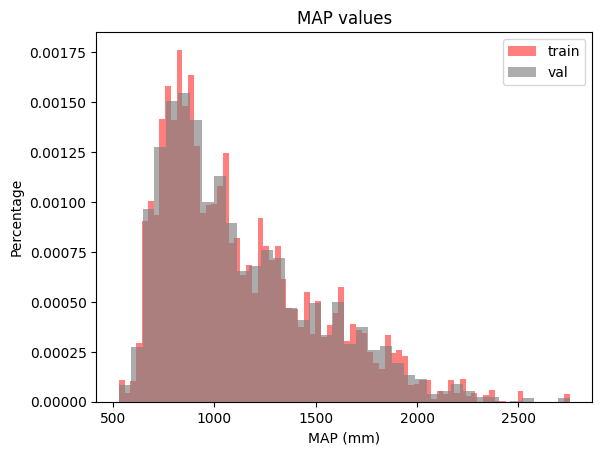

In [16]:
plt.hist(train_dfs['3']['MAP(mm)'], bins='auto', alpha=0.5, label='train', density=True, color='red')
plt.hist(val_dfs['3']['MAP(mm)'], bins='auto', alpha=0.65, label='val', density=True, color='gray')
plt.ylabel('Percentage')
plt.title('MAP values')
plt.xlabel('MAP (mm)')
plt.legend()
plt.show()

(array([1.77345562e-02, 3.22446477e-03, 8.06116192e-03, 9.67339431e-03,
        4.83669715e-03, 8.06116192e-03, 1.61223238e-02, 2.57957182e-02,
        1.12856267e-02, 2.74079505e-02, 2.90201829e-02, 3.22446477e-02,
        2.41834858e-02, 3.06324153e-02, 2.74079505e-02, 4.99792039e-02,
        5.80403658e-02, 6.61015278e-02, 1.06407337e-01, 1.19305196e-01,
        1.62835471e-01, 1.80570027e-01, 2.33773696e-01, 2.93426294e-01,
        4.09507026e-01, 4.85281948e-01, 5.91689285e-01, 7.12606714e-01,
        9.09299065e-01, 1.10115472e+00, 1.27366358e+00, 1.58804890e+00,
        1.76539446e+00, 2.03302504e+00, 2.38610393e+00, 2.71338710e+00,
        2.98101768e+00, 3.46952409e+00, 3.73070574e+00, 4.14666169e+00,
        4.51263844e+00, 4.78833018e+00, 5.12528675e+00, 5.60734423e+00,
        5.68795585e+00, 6.07489162e+00, 6.10552404e+00, 6.44731731e+00,
        6.48278642e+00, 6.73913137e+00, 7.12284267e+00, 7.15025062e+00,
        7.23247448e+00, 7.03094543e+00, 7.19216867e+00, 7.374350

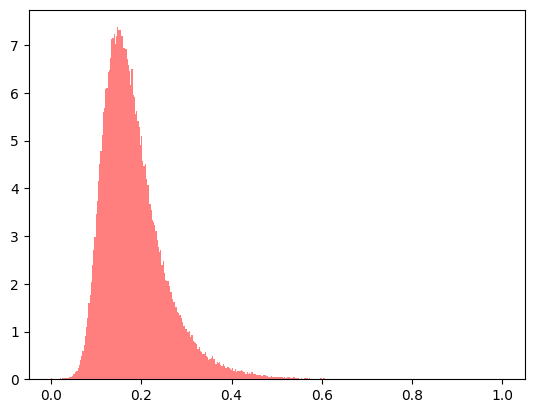

In [17]:
#create a global list of ams
ams_global =  list(chain.from_iterable([train_dfs[duration]['AMS'] for duration in train_dfs]))
#remove nan values from the list
ams_global = [x for x in ams_global if str(x) != 'nan']
#plot the histogram
plt.hist(ams_global, bins='auto', alpha=0.5, label='train', density=True, color='red')

2024-01-16 10:09:26.078 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=382.485734)
2024-01-16 10:09:26.084 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=48.137398)
2024-01-16 10:09:28.856 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=9.886283)
2024-01-16 10:09:37.003 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=10.301203)


{'uniform': (0.0, 1.0),
 'norm': (0.1840038480890943, 0.07289042086394834),
 'gamma': (7.455322492620923, -0.0006034185645873832, 0.024761770048081527),
 'beta': (7.344497374416402,
  1492966.2924921117,
  -0.0005040679872198388,
  37538.47002408977)}

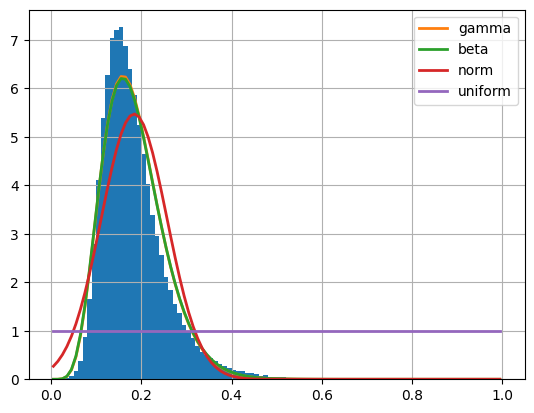

In [23]:
#Fit distribution
ams_global_np = np.array(ams_global)
f = Fitter(ams_global, distributions=['beta', 'gamma', 'norm', 'uniform'])
f.fit()
f.summary()

In [29]:
a, b, loc, scale  = f.fitted_param['beta']

In [28]:
print("alpha",a)
print("beta",b)

alpha 7.344497374416402
beta 1492966.2924921117


In [28]:
def build_nn_beta_model(input_shape, hidden, a=1, b=1):
    model_in = keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    log_rate = layers.Dense(1, activation='linear')(x)
    lf = lambda t: tfp.distributions.Beta(a,b)
    model_out = tfp.layers.DistributionLambda(lf)(log_rate)
    model = keras.Model(model_in, model_out)
    return model

In [29]:
build_nn_beta_model(input_shape=len(ams_1,), hidden=[], a=a, b=b)

In [53]:
train_df.head(5)
for x in [1,3,6,12,24]:
  train_df["AMS_" + str(x)] = [np.nanmean(sublist) for sublist in train_df["AMS_"+str(x)]]


In [55]:
train_df.head(5)

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,AMS_1,AMS_3,AMS_6,AMS_12,AMS_24,IdD_1,IdD_3,IdD_6,IdD_12,IdD_24
0,9380,'Melegnano',90.964295,3.898290,0.858622,0.606050,152.281257,104.700774,233.903377,46.875647,...,0.174033,0.174033,0.174033,0.174033,0.174033,31.500000,38.638095,48.742857,59.577273,72.904545
1,12163,'Fossano_2',360.764973,9.797826,1.848248,2.946933,189.374908,118.169549,359.137335,341.587794,...,0.135742,0.135742,0.135742,0.135742,0.135742,24.569231,29.484615,36.923077,46.400000,59.692308
2,9014,'Barni',767.637133,124.744350,22.700332,12.193675,189.562921,99.345678,246.645541,497.279626,...,0.315391,0.315391,0.315391,0.315391,0.315391,57.085714,79.028571,89.342857,100.114286,118.857143
3,21018,'Brendola',157.061393,90.859242,11.222639,8.708569,187.641838,59.111240,68.528559,36.508654,...,0.193054,0.193054,0.193054,0.193054,0.193054,34.942857,42.300000,51.878571,66.928571,81.814286
4,8072,'Colle_Del_Melogno',1017.392522,148.313182,20.703809,7.836887,164.489004,67.864609,325.281240,363.897139,...,0.184925,0.184925,0.184925,0.184925,0.184925,33.471429,61.000000,86.950000,117.137500,151.655357
